In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum 
from mpl_toolkits import mplot3d
from scipy.interpolate import RegularGridInterpolator

In [2]:
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

def GeneratePathsGBM(NoOfPaths,NoOfSteps,T,r,sigma,S_0):    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    time = np.zeros([NoOfSteps+1])
        
    X[:,0] = np.log(S_0)
    
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):

    # Making sure that samples from the normal distribution have mean 0 and variance 1

        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        X[:,i+1] = X[:,i] + (r - 0.5 * sigma * sigma) * dt + sigma * (W[:,i+1]-W[:,i])
        time[i+1] = time[i] +dt
        
    # Compute exponent of ABM

    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

# Black-Scholes call option price

def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * (T-t)) / (sigma * np.sqrt(T-t))
    d2    = d1 - sigma * np.sqrt(T-t)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * (T-t))
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * (T-t)) - st.norm.cdf(-d1)*S_0
    return value

def BS_Delta(CP,S_0,K,sigma,t,T,r):
    # When defining a time grid it may happen that the last grid point 
    # lies slightly a bit behind the maturity time

    if t-T>10e-20 and T-t<10e-7:
        t=T
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * \
             (T-t)) / (sigma * np.sqrt(T-t))
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1)
    elif CP == OptionType.PUT:
       value = st.norm.cdf(d1)-1.0
    return value


def mainCalculation():
    NoOfPaths = 1000
    NoOfSteps = 200
    T         = 1.0
    r         = 0.1
    sigma     = 0.2
    s0        = 1.0
    K         = [0.95]
    CP        = OptionType.CALL
    
    np.random.seed(1)
    Paths = GeneratePathsGBM(NoOfPaths,NoOfSteps,T,r,sigma,s0)
    time  = Paths["time"]
    S     = Paths["S"]
    
    # Setting up some handy lambda values

    C = lambda t,K,S0: BS_Call_Put_Option_Price(CP,S0,K,sigma,t,T,r)
    Delta = lambda t,K,S0: BS_Delta(CP,S0,K,sigma,t,T,r)
    
    # Setting up the initial portfolio

    PnL = np.zeros([NoOfPaths,NoOfSteps+1])
    delta_init= Delta(0.0,K,s0)
    PnL[:,0] = C(0.0,K,s0) - delta_init * s0
            
    CallM      = np.zeros([NoOfPaths,NoOfSteps+1])
    CallM[:,0] = C(0.0,K,s0)
    DeltaM     = np.zeros([NoOfPaths,NoOfSteps+1])
    DeltaM[:,0] = Delta(0,K,s0)
    
    for i in range(1,NoOfSteps+1):
        dt = time[i] - time[i-1]
        delta_old  = Delta(time[i-1],K,S[:,i-1])
        delta_curr = Delta(time[i],K,S[:,i])
        
        PnL[:,i]    =  PnL[:,i-1]*np.exp(r*dt) - (delta_curr-delta_old)*S[:,i] # PnL
        CallM[:,i]  = C(time[i],K,S[:,i])
        DeltaM[:,i] = delta_curr
    
    # Final transaction, payment of the option (if in the money) and selling the hedge

    PnL[:,-1] = PnL[:,-1] -np.maximum(S[:,-1]-K,0) +  DeltaM[:,-1]*S[:,-1]
    
    # We plot only one path at the time

    path_id = 13
    plt.figure(1)
    plt.plot(time,S[path_id,:])
    plt.plot(time,CallM[path_id,:])
    plt.plot(time,DeltaM[path_id,:])
    plt.plot(time,PnL[path_id,:])
    plt.legend(['Stock','CallPrice','Delta','PnL'])
    plt.grid()
    
    # Plot the histogram of the PnL

    plt.figure(2)
    plt.hist(PnL[:,-1],50)
    plt.grid()
    plt.xlim([-0.1,0.1])
    plt.title('histogram of P&L')
    
    # Analysis for each path

    for i in range(0,NoOfPaths):
        print('path_id = {0:2d}, PnL(t_0)={1:0.4f}, PnL(Tm-1) ={2:0.4f},S(t_m) = {3:0.4f}, max(S(tm)-K,0)= {4:0.4f}, PnL(t_m) = {5:0.4f}'.format(i,PnL[0,0],
              PnL[i,-2],S[i,-1],np.max(S[i,-1]-K,0),PnL[i,-1]))


<ipython-input-2-4cf245057293>:50: RuntimeWarning: divide by zero encountered in true_divide
  d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * \
<ipython-input-2-4cf245057293>:35: RuntimeWarning: invalid value encountered in sqrt
  * (T-t)) / (sigma * np.sqrt(T-t))
<ipython-input-2-4cf245057293>:36: RuntimeWarning: invalid value encountered in sqrt
  d2    = d1 - sigma * np.sqrt(T-t)


path_id =  0, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9462,S(t_m) = 1.4569, max(S(tm)-K,0)= 0.5069, PnL(t_m) = 0.0033
path_id =  1, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9513,S(t_m) = 1.0439, max(S(tm)-K,0)= 0.0939, PnL(t_m) = -0.0018
path_id =  2, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9505,S(t_m) = 1.3998, max(S(tm)-K,0)= 0.4498, PnL(t_m) = -0.0010
path_id =  3, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.0015,S(t_m) = 0.8577, max(S(tm)-K,0)= -0.0923, PnL(t_m) = -0.0015
path_id =  4, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9480,S(t_m) = 1.3177, max(S(tm)-K,0)= 0.3677, PnL(t_m) = 0.0015
path_id =  5, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.8128,S(t_m) = 0.9499, max(S(tm)-K,0)= -0.0001, PnL(t_m) = 0.0040
path_id =  6, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9490,S(t_m) = 1.6110, max(S(tm)-K,0)= 0.6610, PnL(t_m) = 0.0005
path_id =  7, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9510,S(t_m) = 1.1789, max(S(tm)-K,0)= 0.2289, PnL(t_m) = -0.0014
path_id =  8, PnL(t_0)=-0.6397, PnL(Tm-1) =-0.9574,S(t_m) = 1.1829, max(S(tm)-K,0)= 0.2329, PnL(t_m) = -0.0079
pat

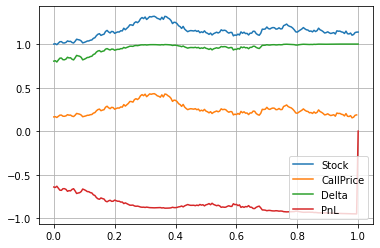

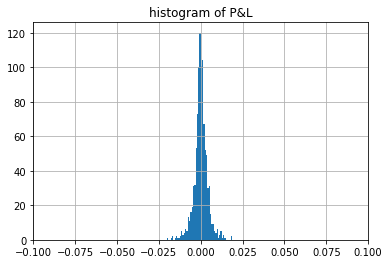

In [3]:
mainCalculation()